### Setup Environment:

In [1]:
from src.get_dataset import get_dataset, split_data
from src.data_loader import BRSETDataset, process_labels
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
import torch
import torch.nn as nn

import torch.optim as optim
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np

# loss function and optimizer
from src.FocalLoss import BinaryFocalLoss, FocalLoss

# train and test functions
from src.train import train
from src.test import test

In [2]:
# Constants:
DATASET = '/opc/davidres/retina/mbrset/data'
DOWNLOAD = False
SHAPE = (224, 224)
IMAGES = os.path.join(DATASET, 'mBRSET/')
LABEL = 'insurance'
TEST_SIZE = 0.2
UNDERSAMPLE = False

LABELS_PATH = os.path.join(DATASET, 'labels.csv')
IMAGE_COL = 'file'

"""
Dataset Mean and Std:
NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

ImageNet Mean and Std:
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
"""

NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD =  [0.229, 0.224, 0.225]

BACKBONE = 'convnextv2_384'
MODE = 'fine_tune'
backbone_mode = 'fine_tune'

HIDDEN = [128]
num_classes = 2

BATCH_SIZE = 20
NUM_WORKERS = 4

LOSS = 'focal_loss'
OPTIMIZER = 'adam'

# Define your hyperparameters
num_epochs = 50
learning_rate = 1e-5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read csv file:

In [3]:
df = get_dataset(DATASET, download=DOWNLOAD, info=False)
df = df[df['file'] != '985.1.jpg'] # this is missing
df.head()

loading csv file in /home/chenweiw/retina/mbrset/data/labels.csv


,patient,age,sex,dm_time,insulin,insulin_time,oraltreatment_dm,systemic_hypertension,insurance,educational_level,...,nephropathy,neuropathy,diabetic_foot,file,laterality,final_artifacts,final_quality,final_icdr,final_edema,normality
0,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,0.0,0.0,1.1.jpg,right,yes,yes,4.0,no,abnormal
1,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,0.0,0.0,1.2.jpg,right,yes,yes,4.0,no,abnormal
2,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,0.0,0.0,1.3.jpg,left,yes,yes,4.0,no,abnormal
3,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,0.0,0.0,1.4.jpg,left,yes,yes,4.0,no,abnormal
4,10,63,0,7.0,0.0,NaN,1.0,1.0,0.0,2.0,...,0.0,0.0,0.0,10.1.jpg,right,yes,yes,0.0,no,abnormal


In [4]:
df.insurance.value_counts()

0.0    4719
1.0     396
Name: insurance, dtype: int64

In [5]:

df[LABEL] = df[LABEL].apply(lambda x: '0' if x == 0 else '1')

In [6]:
df[LABEL].value_counts()

0    4719
1     444
Name: insurance, dtype: int64

Train data shape: (4130, 25)
Test data shape: (1033, 25)


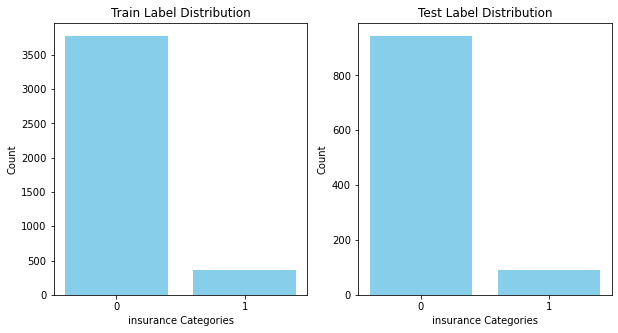

Getting validation set...


In [7]:
# Split dataset into train, test and validation:
df_train, df_test = split_data(df, LABEL, TEST_SIZE, undersample=False)
print('Getting validation set...')
# df_test, df_val = split_data(df_test, LABEL, 0.20)
df_val=df_test

### Dataloaders

In [8]:
# Train the one hot encoder on the train set and get the labels for the test and validation sets:
train_labels, mlb, train_columns = process_labels(df_train, col=LABEL)

In [9]:
# Define the target image shape
SHAPE = (224, 224)  # Adjust to your desired image size

train_transforms = transforms.Compose([
    transforms.Resize((SHAPE)),
    # transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(25),  # Randomly rotate the image by up to 10 degrees
])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))


In [10]:
# Create the custom dataset
train_dataset = BRSETDataset(
    df_train, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms
)

test_dataset = BRSETDataset(
    df_test, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

val_dataset = BRSETDataset(
    df_val, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


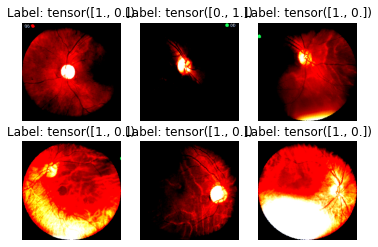

In [11]:
# Print 6 samples with their labels
# Iterate through the DataLoader and plot the images with labels
for batch in train_dataloader:
    images, labels = batch['image'], batch['labels']

    for i in range(len(images)):
        if i == 6:
            break
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) from (C, H, W)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()
    break

### Model

In [12]:
# Create a DataLoader to generate embeddings
#model = get_retfound(weights='/scratch/liyues_root/liyues/chenweiw/retina_datasets/retfound_weigths/RETFound_cfp_weights.pth', num_classes=3)
# Create a DataLoader to generate embeddings
from transformers import ConvNextV2Model, ConvNextV2ForImageClassification
import torch

# Load the pre-trained ConvNeXt V2 model
model_name = "facebook/convnextv2-large-22k-384"
model = ConvNextV2ForImageClassification.from_pretrained(model_name)

# Modify the classifier head according to the new number of classes
model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, [0,1])

### Training:

In [13]:
if LOSS == 'focal_loss':
    class_distribution = train_dataloader.dataset.labels.sum(axis=0)
    print(f'Class distribution: {class_distribution}')
    class_dis = np.array(class_distribution)
    class_weights =1-class_dis/np.sum(class_dis)
    weights = torch.tensor(class_weights).to(device)
    #criterion = FocalLoss()  # Focal Loss
    criterion = FocalLoss(gamma=2, alpha=weights)
else:
    # Assuming train_loader.dataset.labels is a one-hot representation
    class_indices = np.argmax(train_dataloader.dataset.labels, axis=1)

    # Compute class weights using class indices
    class_weights = compute_class_weight('balanced', classes=np.unique(class_indices), y=class_indices)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    print(class_weights)
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
    #criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

Class distribution: [3775  355]


In [ ]:
model = train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs, save=True, device=device, backbone=f'{BACKBONE}_{num_classes}class_{LABEL}')

100%|██████████| 52/52 [00:25<00:00,  2.04it/s]


Epoch 1, Train Loss: 0.028396483319519078, Val Loss: 0.027910563485840194, F1 Score: 0.12515492026770222, acc0.12681510164569215
cm[[ 43 901]
 [  1  88]]


100%|██████████| 52/52 [00:25<00:00,  2.05it/s]


Epoch 2, Train Loss: 0.026619790670808385, Val Loss: 0.026406089381243173, F1 Score: 0.5387804566909045, acc0.7560503388189739
cm[[745 199]
 [ 53  36]]


100%|██████████| 52/52 [00:25<00:00,  2.05it/s]


Epoch 3, Train Loss: 0.024287171056719074, Val Loss: 0.028282992810440753, F1 Score: 0.5289123402013484, acc0.7318489835430784
cm[[717 227]
 [ 50  39]]


100%|██████████| 52/52 [00:24<00:00,  2.12it/s]


Epoch 4, Train Loss: 0.02299213626507472, Val Loss: 0.02663431130349636, F1 Score: 0.475928407047961, acc0.611810261374637
cm[[579 365]
 [ 36  53]]


100%|██████████| 52/52 [00:24<00:00,  2.12it/s]


Epoch 5, Train Loss: 0.01824729463899877, Val Loss: 0.027542106001279675, F1 Score: 0.4455091908933603, acc0.5411423039690223
cm[[494 450]
 [ 24  65]]


100%|██████████| 52/52 [00:24<00:00,  2.12it/s]


Epoch 6, Train Loss: 0.016239147320623704, Val Loss: 0.033476044271642774, F1 Score: 0.5033199010898434, acc0.7153920619554696
cm[[707 237]
 [ 57  32]]


100%|██████████| 52/52 [00:24<00:00,  2.09it/s]


Epoch 7, Train Loss: 0.012178098898468728, Val Loss: 0.04363625258198366, F1 Score: 0.626856023878781, acc0.8712487899322362
cm[[868  76]
 [ 57  32]]


100%|██████████| 52/52 [00:25<00:00,  2.02it/s]


Epoch 8, Train Loss: 0.008745877838053556, Val Loss: 0.03365429485431658, F1 Score: 0.5078269224899102, acc0.6524685382381413
cm[[617 327]
 [ 32  57]]


100%|██████████| 52/52 [00:25<00:00,  2.05it/s]


Epoch 9, Train Loss: 0.007932072662824882, Val Loss: 0.0462052882469904, F1 Score: 0.5946524675621665, acc0.8538238141335914
cm[[854  90]
 [ 61  28]]


100%|██████████| 52/52 [00:25<00:00,  2.05it/s]


Epoch 10, Train Loss: 0.005110321992615706, Val Loss: 0.054739547678484365, F1 Score: 0.6526833053148843, acc0.8867376573088093
cm[[882  62]
 [ 55  34]]


100%|██████████| 52/52 [00:24<00:00,  2.09it/s]


Epoch 11, Train Loss: 0.004324814988930646, Val Loss: 0.07521492628494833, F1 Score: 0.6490500386405976, acc0.9119070667957405
cm[[918  26]
 [ 65  24]]


100%|██████████| 52/52 [00:26<00:00,  1.99it/s]


Epoch 12, Train Loss: 0.0030398887580998495, Val Loss: 0.08233405443836371, F1 Score: 0.6617590784464564, acc0.9196515004840271
cm[[926  18]
 [ 65  24]]


100%|██████████| 52/52 [00:25<00:00,  2.08it/s]


Epoch 13, Train Loss: 0.0012145848419437982, Val Loss: 0.09506221996623655, F1 Score: 0.6776883896647102, acc0.9283639883833494
cm[[935   9]
 [ 65  24]]


100%|██████████| 52/52 [00:25<00:00,  2.04it/s]


Epoch 14, Train Loss: 0.000952291151615526, Val Loss: 0.08395190943282124, F1 Score: 0.6435636006094861, acc0.8906098741529526
cm[[890  54]
 [ 59  30]]


100%|██████████| 52/52 [00:25<00:00,  2.03it/s]


Epoch 15, Train Loss: 0.0006910983879892237, Val Loss: 0.12805334890684278, F1 Score: 0.658458914836599, acc0.9264278799612778
cm[[936   8]
 [ 68  21]]


100%|██████████| 52/52 [00:24<00:00,  2.09it/s]


Epoch 16, Train Loss: 0.0008814320723380977, Val Loss: 0.09564527463659872, F1 Score: 0.6814135763737491, acc0.9157792836398838
cm[[916  28]
 [ 59  30]]


100%|██████████| 52/52 [00:25<00:00,  2.04it/s]


Epoch 17, Train Loss: 0.0004097975743783589, Val Loss: 0.0903064547939301, F1 Score: 0.6864810960804717, acc0.9186834462729913
cm[[919  25]
 [ 59  30]]


100%|██████████| 52/52 [00:24<00:00,  2.10it/s]


Epoch 18, Train Loss: 0.003840247315584321, Val Loss: 0.04714583194268366, F1 Score: 0.6196680151886156, acc0.8393030009680542
cm[[826 118]
 [ 48  41]]


100%|██████████| 52/52 [00:25<00:00,  2.04it/s]


Epoch 19, Train Loss: 0.004431289185352701, Val Loss: 0.05016568490715984, F1 Score: 0.6446841776110068, acc0.850919651500484
cm[[833 111]
 [ 43  46]]


100%|██████████| 52/52 [00:25<00:00,  2.03it/s]


Epoch 20, Train Loss: 0.0016429538080723397, Val Loss: 0.08024275188066755, F1 Score: 0.6671768022553363, acc0.9070667957405615
cm[[907  37]
 [ 59  30]]


100%|██████████| 52/52 [00:25<00:00,  2.04it/s]


Epoch 21, Train Loss: 0.0004653223137949312, Val Loss: 0.0951436415468309, F1 Score: 0.6876159684603121, acc0.9215876089060987
cm[[923  21]
 [ 60  29]]


100%|██████████| 52/52 [00:24<00:00,  2.08it/s]


Epoch 22, Train Loss: 0.000345994910382751, Val Loss: 0.09380454107122205, F1 Score: 0.7011793502447707, acc0.9244917715392061
cm[[924  20]
 [ 58  31]]


100%|██████████| 52/52 [00:24<00:00,  2.14it/s]


Epoch 23, Train Loss: 0.0001873779740754109, Val Loss: 0.12394409796371082, F1 Score: 0.6703730976926854, acc0.9244917715392061
cm[[931  13]
 [ 65  24]]


100%|██████████| 52/52 [00:24<00:00,  2.14it/s]


Epoch 24, Train Loss: 0.00011759810449539277, Val Loss: 0.11980288823944928, F1 Score: 0.6853845435385558, acc0.9273959341723137
cm[[932  12]
 [ 63  26]]


100%|██████████| 52/52 [00:24<00:00,  2.14it/s]


Epoch 25, Train Loss: 0.0001841326035993415, Val Loss: 0.1105632557714321, F1 Score: 0.70280223257955, acc0.9273959341723137
cm[[928  16]
 [ 59  30]]


100%|██████████| 52/52 [00:24<00:00,  2.14it/s]


Epoch 26, Train Loss: 5.2750469264256774e-05, Val Loss: 0.11824864940759792, F1 Score: 0.6982106910310437, acc0.9293320425943853
cm[[932  12]
 [ 61  28]]


100%|██████████| 52/52 [00:25<00:00,  2.07it/s]


Epoch 27, Train Loss: 0.00011631491728251599, Val Loss: 0.12421574820956056, F1 Score: 0.7005656356742189, acc0.9283639883833494
cm[[930  14]
 [ 60  29]]


100%|██████████| 52/52 [00:25<00:00,  2.08it/s]


Epoch 28, Train Loss: 0.0071934544689528975, Val Loss: 0.05613996601179959, F1 Score: 0.6323489803770681, acc0.856727976766699
cm[[846  98]
 [ 50  39]]


100%|██████████| 52/52 [00:24<00:00,  2.08it/s]


Epoch 29, Train Loss: 0.001543463911901568, Val Loss: 0.06006615054838431, F1 Score: 0.6455411198435679, acc0.8586640851887706
cm[[844 100]
 [ 46  43]]


100%|██████████| 52/52 [00:25<00:00,  2.03it/s]


Epoch 30, Train Loss: 0.0006537542489381475, Val Loss: 0.08767861425216185, F1 Score: 0.6875378100423473, acc0.914811229428848
cm[[913  31]
 [ 57  32]]


 17%|█▋        | 35/207 [00:21<01:30,  1.90it/s]

### Test

In [ ]:
test(model, test_dataloader, saliency=True, device=device)

In [ ]:
# Good quality images
adequate_df = df_test[df_test['final_quality'] == 'yes']

# Bad quality images
inadequate_df = df_test[df_test['final_quality'] == 'no']

adequate_dataset = BRSETDataset(
    adequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

inadequate_dataset = BRSETDataset(
    inadequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

adequate_dataloader = DataLoader(adequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
inadequate_dataloader = DataLoader(inadequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

#### Adequate image quality

In [ ]:
test(model, adequate_dataloader, saliency=True, device=device, save=True)

#### Inadequate image quality

In [ ]:
test(model, inadequate_dataloader, saliency=True, device=device)